Our goal is to use this industrial scale dataset to predict if a customer will default in the future. We aim to put together a quick and rough solution.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


This data set is too large to be loaded as a csv file. We convert the data from csv to parquet and then load the parquet format into a pandas dataframe. 

Next, we take a preview of our data.

In [2]:
import pandas as pd
df=pd.read_parquet('/kaggle/input/amex-parquet/train_data.parquet')
print(df.head)

<bound method NDFrame.head of                                                customer_ID         S_2  \
0        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09   
1        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07   
2        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28   
3        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13   
4        0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16   
...                                                    ...         ...   
5531446  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-11-05   
5531447  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2017-12-23   
5531448  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-01-06   
5531449  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-02-06   
5531450  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-03-14   

              P_2      D_39       B_1       B_2       R_1       S_3      D_41  \


Due to hardware limitations we will need to reduce the size of our data. We note the customer ID and the date columns. 

There are four non-numeric data types. Let's convert these so we may apply a logistic regression model.

Let's plot our columns.

In [3]:
#hist = df.hist(bins=10, figsize = (40,200), layout=(-1,4) )

Let's find the columns with a significant amount of NaN values. 

In [4]:
temp = [column for column in df.columns if df[column].isnull().sum()/len(df) >= 0.9]
print(len(temp))

#drop columns with high freq of NaN
df.drop(temp, axis=1, inplace=True)

print( len(df.columns) )

18
173


We choose to impute by selecting the most recent transaction from each customer. We fill missing data from previous records. 

In [5]:
#using only most recent transaction from each customer
temp = df.shape
df=df.set_index(['customer_ID'])
df=df.ffill()
df=df.bfill()
df=df.reset_index()

df=df.groupby('customer_ID').tail(1)
df=df.set_index(['customer_ID'])

#Drop date column since it
df.drop(['S_2'],axis=1,inplace=True)

print(temp, df.shape)


temp = [column for column in df.columns if df[column].isnull().sum()/len(df) >0]
print(len(temp))

(5531451, 173) (458913, 171)
0


This magically removes all missing data... ??

Lets separate our labels from our dataset.

In [6]:
df_label = df.iloc[:,len(df.columns)-1]
df = df.iloc[:,0:len(df.columns)-1]
print(df_label.sum()/len(df_label))

0.2589336105100531


Our train data contains ~25% positive cases.

We aim to remove data columns that have too high a correlation as logistic regression requires it. (why? 

In [7]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
import numpy as np
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find and drop columns with high correl
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df.drop(to_drop, axis=1, inplace=True)

print(len(to_drop),df.shape)

23 (458913, 147)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


To further reduce the degrees of freedom we remove columns with low variance

In [8]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

temp = df.drop(['D_63', 'D_64'], axis=1)

# Initialize and fit the method
vt = VarianceThreshold(threshold = float(0.2))
vt.fit(temp)

#columns with sufficient variance
keep = list(compress(temp.columns, vt.get_support()))

#dropped = ['D_63', 'D_64', 'customer_ID', 'S_2']

keep.extend(['D_63', 'D_64',])

#keep = keep + dropped
#keep.append('D_64')
df=df[keep]
keep.extend([ 'customer_ID', 'S_2'])
#keep.append('customer_ID')
#keep.append('S_2')
len(keep)

30

In [9]:
""""
#removing outliers
print(df1.shape)

df1 = df1[df1['R_6'] < df1['R_6'].quantile(0.97)]
print(df1['R_6'].max())
print(df1.shape)"""

'"\n#removing outliers\nprint(df1.shape)\n\ndf1 = df1[df1[\'R_6\'] < df1[\'R_6\'].quantile(0.97)]\nprint(df1[\'R_6\'].max())\nprint(df1.shape)'

In [10]:
"""#df1.iloc[:100000,7].value_counts()
print(df1.iloc[:,1].head())


#What type of variable for dates
df1['S_2'] = pd.to_datetime(df1['S_2'])
df1['S_2'] = pd.to_numeric(df1['S_2'])

#normalizing
#df1['S_2'] = (df1['S_2']-df1['S_2'].min())/(df1['S_2'].max() - df1['S_2'].min())
print(df1['S_2'].head())

df1['S_2'] = pd.to_timedelta(df1['S_2'])
print(df1.iloc[:,1].dt.total_seconds())
"""

"#df1.iloc[:100000,7].value_counts()\nprint(df1.iloc[:,1].head())\n\n\n#What type of variable for dates\ndf1['S_2'] = pd.to_datetime(df1['S_2'])\ndf1['S_2'] = pd.to_numeric(df1['S_2'])\n\n#normalizing\n#df1['S_2'] = (df1['S_2']-df1['S_2'].min())/(df1['S_2'].max() - df1['S_2'].min())\nprint(df1['S_2'].head())\n\ndf1['S_2'] = pd.to_timedelta(df1['S_2'])\nprint(df1.iloc[:,1].dt.total_seconds())\n"

Now lets take a look at our data types.

In [11]:
print(df.dtypes.value_counts())

float32    26
object      2
dtype: int64


Convert our object columns to numeric via one hot encoding

In [12]:
df = pd.get_dummies(df)
print(df['D_64_-1'].sum())
df.drop(['D_64_-1'], axis=1, inplace = True)
print(df.shape)

1865
(458913, 35)


In [13]:
#Handling missing values
#from sklearn.impute import SimpleImputer
#my_imputer = SimpleImputer()
#df1.iloc[:,:] = my_imputer.fit_transform(df1.iloc[:,:])

Reshaping data for model training

In [14]:
X = df.iloc[:, :].values.reshape(-1, len(df.columns))
Y = df_label
#Y = df_label.iloc[:len(df1), 1].values.reshape(-1, 1)

We scale our data for better results

In [15]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [16]:
from sklearn.linear_model import LogisticRegression
# create object for the class
log = LogisticRegression()
log.fit(X_scaled, Y) 
Y_pred = log.predict(X_scaled)

print(Y_pred, np.sum(Y_pred))
print(log.score(X_scaled, Y))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[0 0 0 ... 0 1 0] 98474
0.8519545098962112


Accuracy: 0.852
0.7792589491433799


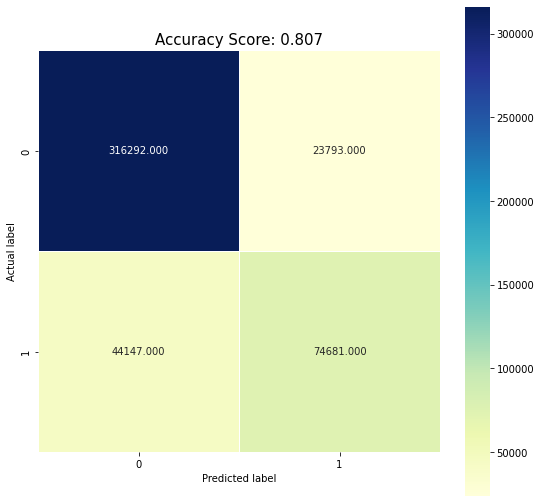

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(Y, Y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'YlGnBu');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(log.score(X, Y),3))
plt.title(all_sample_title, size = 15);

print('Accuracy:',round(metrics.accuracy_score(Y, Y_pred),3))
metrics.roc_curve(Y, Y_pred)
print(metrics.roc_auc_score(Y, Y_pred))

In [18]:
"""
#trying random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier(n_estimators=400, max_features='sqrt', bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_jobs=-1)
#rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=1, n_jobs = -1)
# Fit the random search model
model.fit(X,Y)"""

"\n#trying random forest\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV, GridSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n        

In [19]:
"""Y_pred = model.predict_proba(X)
Y_pred = Y_pred[:,1]
print(Y_pred.shape, Y_pred[25:50])"""

'Y_pred = model.predict_proba(X)\nY_pred = Y_pred[:,1]\nprint(Y_pred.shape, Y_pred[25:50])'

In [20]:
"""from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_random_gb = {'learning_rate': np.arange(0.05,0.55, 0.1), 'n_estimators' : [125,150,175], 'subsample' : np.arange(0.3,1.0, 0.1), 'max_depth':[3,4,5]}

mse_random = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_random_gb, n_iter = 10,scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)



mse_random.best_params_={'subsample': 0.5, 'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.15}
mse_random.best_score_ = (0.32263831733224874)**2

mse_random.fit(X,Y)

#Run XGBoost model with the best parameters found
model=XGBClassifier(n_estimators=200,max_depth=3,learning_rate=0.15, subsample=0.5)
model.fit(x_train_split,y_train_split)
#Test the model
y_predict=model.predict(x_test_split)
print('XGBoost Classifier Accuracy: {:.3f}'.format(accuracy_score(y_test_split, y_predict)))"""

"from xgboost import XGBClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\n\nparam_random_gb = {'learning_rate': np.arange(0.05,0.55, 0.1), 'n_estimators' : [125,150,175], 'subsample' : np.arange(0.3,1.0, 0.1), 'max_depth':[3,4,5]}\n\nmse_random = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_random_gb, n_iter = 10,scoring = 'neg_mean_squared_error', cv = 4, verbose = 1)\n\n\n\nmse_random.best_params_={'subsample': 0.5, 'n_estimators': 175, 'max_depth': 3, 'learning_rate': 0.15}\nmse_random.best_score_ = (0.32263831733224874)**2\n\nmse_random.fit(X,Y)\n\n#Run XGBoost model with the best parameters found\nmodel=XGBClassifier(n_estimators=200,max_depth=3,learning_rate=0.15, subsample=0.5)\nmodel.fit(x_train_split,y_train_split)\n#Test the model\ny_predict=model.predict(x_test_split)\nprint('XGBoost Classifier Accuracy: {:.3f}'.format(accuracy_score(y_test_split, y_predict)))"

In [21]:
"""def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
accuracy = evaluate(model, X, Y)

print('Accuracy:{:0.2f}%.'.format( 100 * accuracy))"""

"def evaluate(model, test_features, test_labels):\n    predictions = model.predict(test_features)\n    errors = abs(predictions - test_labels)\n    mape = 100 * np.mean(errors / test_labels)\n    accuracy = 100 - mape\n    print('Model Performance')\n    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))\n    print('Accuracy = {:0.2f}%.'.format(accuracy))\n    \naccuracy = evaluate(model, X, Y)\n\nprint('Accuracy:{:0.2f}%.'.format( 100 * accuracy))"

In [22]:
import gc
#free up ram
del df, df_label
gc.collect()

4989

In [23]:
#run prediction on test data

print(len(keep), keep)
#need to only load some columns due to ram limitations
df2=pd.read_parquet('/kaggle/input/amex-parquet/test_data.parquet', columns =keep)
print(df2.shape)

30 ['B_6', 'B_8', 'D_50', 'B_10', 'B_12', 'R_5', 'D_65', 'D_68', 'R_6', 'B_21', 'D_69', 'R_7', 'B_26', 'S_16', 'R_14', 'R_20', 'S_22', 'S_23', 'S_26', 'D_103', 'B_38', 'B_40', 'D_114', 'D_117', 'D_128', 'D_129', 'D_63', 'D_64', 'customer_ID', 'S_2']
(11363762, 30)


In [24]:
#Handling missing values via imputation
#df2.iloc[:,:] = my_imputer.fit_transform(df2.iloc[:,:])

In [25]:
#using only most recent transaction from each customer
#Does this make sense for test data??
temp = df2.shape
df2=df2.set_index(['customer_ID'])
df2=df2.ffill()
df2=df2.bfill()
df2=df2.reset_index()

df2=df2.groupby('customer_ID').tail(1)
df2=df2.set_index(['customer_ID'])

#Drop date column since it is no longer useful
df2.drop(['S_2'],axis=1,inplace=True)

print(temp, df2.shape)

#inspecting NaN
print('Columns left with NaN:')
for i in range(len(df2.columns)):
    if (df2.iloc[:,i].isnull().sum()/len(df2) > 0):
        print(df2.columns[i], round(df2.iloc[:,i].isnull().sum()/len(df2),2))

(11363762, 30) (924621, 28)
Columns left with NaN:


In [26]:
#one hot encoding
df2 = pd.get_dummies(df2)

In [27]:
from sklearn import preprocessing

X2 = df2.iloc[:, :].values.reshape(-1, len(df2.columns))
scaler = preprocessing.StandardScaler().fit(X2)
X2 = scaler.transform(X2)


Y_pred2 = log.predict(X2)
print(Y_pred2)

df2 = df2.reset_index()

final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})

final.to_csv('submission.csv', index=False)
print(Y_pred2, np.sum(Y_pred2))

#initial score ended as ~50 w/o scaler

[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0] 192266


In [28]:
"""Y_pred2 = model.predict_proba(df2)
Y_pred2 = Y_pred2[:,1]
df2 = df2.reset_index()
print(Y_pred2, np.sum(Y_pred2))
final = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})
print(final)"""

'Y_pred2 = model.predict_proba(df2)\nY_pred2 = Y_pred2[:,1]\ndf2 = df2.reset_index()\nprint(Y_pred2, np.sum(Y_pred2))\nfinal = pd.DataFrame({"customer_ID":df2.customer_ID,"prediction":Y_pred2})\nprint(final)'

In [29]:
final.to_csv('submission.csv', index=False)
print(final)

                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...           0
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...           0
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...           0
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...           0
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...           1
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...           0
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...           0
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...           0
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...           1
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...           0

[924621 rows x 2 columns]
